<a href="https://colab.research.google.com/github/jellycodes/correct-or-incorrect-push-up/blob/main/pushup_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## google colab 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 기존 경로 변경
os.chdir('/content/drive/MyDrive/dataset')

## pushup.zip 압축풀기

In [ ]:
import zipfile
import os
# 폴더가 존재하지 않으면 경로에 압축해제
if not os.path.exists('pushup'):
  path = 'pushup.zip'
  f_zip = zipfile.ZipFile(path)
  f_zip.extractall('./pushup')
  f_zip.close()

##케라스 저장
##모델 생성

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import layers
import numpy as np

# 데이터세트 구성

img_height = 224
img_width = 224
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  'pushup/images/train',
  batch_size=batch_size,
  validation_split=0.2,
  subset='both',
  seed=42,
  shuffle=True,
  image_size=(img_height, img_width)
  )



class_names = train_ds.class_names
print(class_names)

Found 279 files belonging to 2 classes.
Using 224 files for training.
Using 55 files for validation.
['abnormal', 'normal']


In [ ]:

train_aug = tf.keras.Sequential([
        layers.RandomBrightness(0.2),
        layers.RandomFlip(),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.2,0.2)])

def data_augmentation(img, label):
  aug = train_aug(img)
  return aug, label

train_ds = train_ds.map(data_augmentation)
train_ds = train_ds.prefetch(buffer_size=1000)

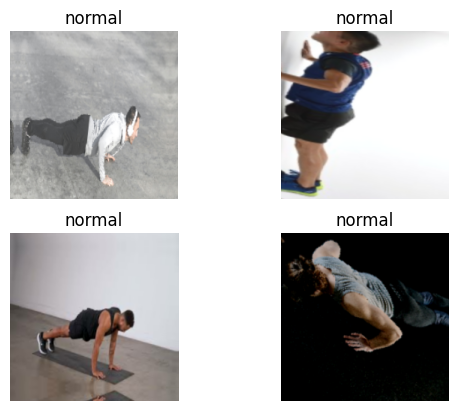

In [ ]:
import matplotlib.pyplot as plt

for feature, label in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(feature[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [ ]:
# MobileNetV3Small 모델 활용
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(img_height,img_width,3),
                                                    include_top=False,
                                                    weights='imagenet')


global_pooling = layers.GlobalMaxPooling2D() #(3)
bn = layers.BatchNormalization()
dr1 = layers.Dropout(0.4)
dense1 = layers.Dense(128)
dr2 = layers.Dropout(0.4)
dense2 = layers.Dense(64)
dr3 = layers.Dropout(0.3)
dense3 = layers.Dense(3)
softmax = layers.Softmax()

inp = tf.keras.Input((img_height,img_width,3))
# x = rescale(inp)
x = base_model(inp)
x = global_pooling(x)
x = bn(x)
x = dr1(x)
x = dense1(x)
x = dr2(x)
x = dense2(x)
x = dr3(x)
x = dense3(x)
out = softmax(x)
model = tf.keras.Model(inp, out, name = 'MobileNet')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path = "/checkpoint/weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)
model.summary()
# history = model.fit(train_ds, epochs=10, validation_data = val_ds, callbacks=[cp_callback])

4334752/4334752 [==============================] - 0s 0us/step
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_max_pooling2d (Glob  (None, 576)               0         
 alMaxPooling2D)                                                 
                                                                 
 batch_normalization (Batch  (None, 576)               2304      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 576)               0    

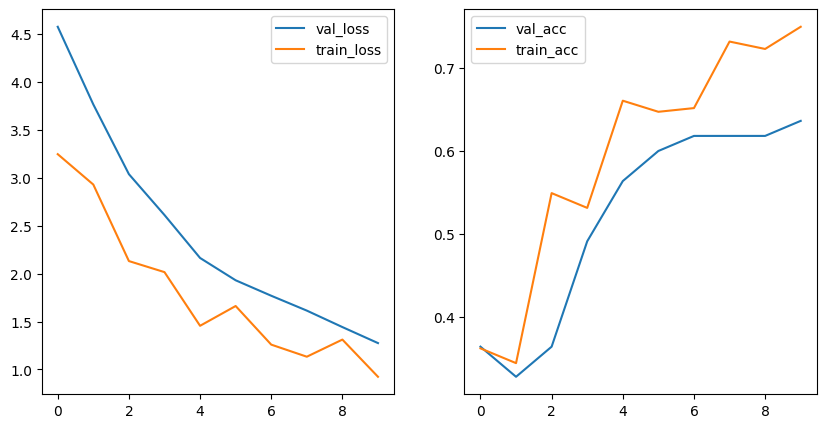

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 변화 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

eps = range(len(val_loss))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(eps, val_loss, label = 'val_loss')
ax1.plot(eps, loss, label = 'train_loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(eps, val_acc, label = 'val_acc')
ax2.plot(eps, acc, label = 'train_acc')
ax2.legend()
plt.show()


### 모델 저장

In [ ]:
import os

# 베스트 에포크 모델 로드
model.load_weights(checkpoint_path)

# 모델 전체 저장
m_path = '/content/drive/MyDrive/model'
os.makedirs(m_path, exist_ok=True)
# .h5 저장
model.save(f"{m_path}/pushup_model.h5", save_format='h5')
# # .pb 저장
# model.save(f"{m_path}/RSP_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 파일 다운로드
import shutil
from google.colab import files

# .h5 형태일 경우
files.download(f"{m_path}/pushup_model.h5")

# .pb 형태일 경우
shutil.make_archive('/pushup_model','zip',f"{m_path}/pushup_model")
files.download('/pushup_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 파이토치 저장
### 모델 생성

In [ ]:
pwd

'/content/drive/MyDrive/dataset'

In [ ]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

NameError: name '_C' is not defined

In [ ]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from pathlib import Path

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=.2),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    # 기본 정보 초기화
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        root = Path(img_dir)
        self.paths = list(root.glob('*/*.*'))
        self.class_name = ['abnormal', 'normal']
        self.cindex = {'abnormal':0,'normal':1}

    # 데이터의 총 개수가 리턴
    def __len__(self):
        return len(self.paths)

    # idx 인자에 호출될 데이터의 인덱스가 입력됨
    # 입력데이터 하나의 구성을 리턴
    def __getitem__(self, idx):
        path = self.paths[idx]
        label = path.parts[-2]
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)
        return image, self.cindex[label]


dataset = CustomImageDataset('./pushup/images/train', transform=train_transforms)

# 평가데이터 분리
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(train_size,val_size)
train_set, val_set = random_split(dataset, [train_size, val_size])

class_names = dataset.class_name

# 각각의 데이터세트에 다른 transform 적용
train_set = Subset(CustomImageDataset('./pushup/images/train', transform=train_transforms), train_set.indices)
val_set = Subset(CustomImageDataset('./pushup/images/train', transform=val_transforms), val_set.indices)


train_loader = DataLoader(train_set,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)

val_loader = DataLoader(val_set,
                        batch_size=32,
                        shuffle=False,
                        num_workers=2)



224 56


In [ ]:
import torch
import torchvision.models as models
from torch import nn

class RSPMCNN(nn.Module):
    def __init__(self):
        super(RSPMCNN, self).__init__()
        self.model = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        nn_feature = self.model.classifier[0].in_features
        self.model.classifier = nn.Identity()
        self.fc1 = nn.Linear(nn_feature, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

In [ ]:
import os

model_name = "pushup_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 모델 생성
model = RSPMCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

# 체크포인트 경로 생성
if not os.path.isdir('/checkpoint'):
    os.mkdir('/checkpoint')

train_loss = []
test_loss = []

# 학습 루프
for epoch in range(10):

    t_acc = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)

        t_acc += acc
        if i % 10 == 0:
            print('.',end='')

    print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {t_acc/(i+1)}")
    train_loss.append(loss.item())

    # 에포크 마다 체크포인트 저장
    checkpoint_path = f"/checkpoint/ckpt_{model_name}{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)

    # 평가
    v_acc = 0
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)
            v_acc += acc

        print(f"Epoch: {epoch}, Val_Loss: {loss.item()}, Val_Accuracy: {v_acc/(i+1)}")
        test_loss.append(loss.item())


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


cpu


100%|██████████| 9.83M/9.83M [00:00<00:00, 28.3MB/s]


.Epoch: 0, Loss: 1.0337899923324585, Accuracy: 0.4419642984867096
Epoch: 0, Val_Loss: 1.0039842128753662, Val_Accuracy: 0.8020833730697632
.Epoch: 1, Loss: 0.9269611835479736, Accuracy: 0.8482142686843872
Epoch: 1, Val_Loss: 0.9146648049354553, Val_Accuracy: 0.9479166269302368
.Epoch: 2, Loss: 0.8848353028297424, Accuracy: 0.9017857313156128
Epoch: 2, Val_Loss: 0.8342278003692627, Val_Accuracy: 0.890625
.Epoch: 3, Loss: 0.8206917643547058, Accuracy: 0.90625
Epoch: 3, Val_Loss: 0.7654410004615784, Val_Accuracy: 0.90625
.Epoch: 4, Loss: 0.6934142708778381, Accuracy: 0.9285714030265808
Epoch: 4, Val_Loss: 0.7006175518035889, Val_Accuracy: 0.9270833730697632
.Epoch: 5, Loss: 0.6799447536468506, Accuracy: 0.9508928656578064
Epoch: 5, Val_Loss: 0.6520163416862488, Val_Accuracy: 0.9635416269302368
.Epoch: 6, Loss: 0.6279963254928589, Accuracy: 0.9642857313156128
Epoch: 6, Val_Loss: 0.6228753328323364, Val_Accuracy: 0.984375
.Epoch: 7, Loss: 0.628787100315094, Accuracy: 0.9776785969734192
Epoc

### 모델 저장

In [ ]:
import os
import numpy as np

# 베스트 케이스 로드
best_epoch = np.argmin(test_loss)
checkpoint_path = f"/checkpoint/ckpt_{model_name}{best_epoch}.pt"
model.load_state_dict(torch.load(checkpoint_path))

# 모델 전체 저장
m_path = '/content/drive/MyDrive/model'
os.makedirs(m_path, exist_ok=True)
torch.save(model, f"{m_path}/{model_name}.pt")

# 텐서 라이트로 저장
### 케라스 모델을 텐서 라이트로

In [ ]:
import tensorflow as tf
from google.colab import files
# 저장된 모델 다운로드

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/pushup_model.tflite', 'wb') as f:
    f.write(tflite_model)

files.download('/pushup_model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 파이토치 모델을 텐서 라이트로

1.   토치 모델을 ONNX 모델로 변경
2.   ONNX 모델을 텐서 모델로 변경
3.   텐서 모델을 텐서 라이트 모델로 변경



In [ ]:
dummy_input = torch.randn(1, 3, 224, 224) # 예: 이미지 분류 모델의 경우
print(dummy_input)
# 모델을 평가 모드로 설정
model.eval()

# PyTorch 모델을 ONNX 형식으로 변환 및 저장
torch.onnx.export(model, dummy_input, "/pushup_model.onnx", export_params=True,
                  input_names=['input'], output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

tensor([[[[ 0.5819, -0.5232,  2.0158,  ..., -0.5055, -0.2350,  0.4597],
          [ 0.5508, -0.5762,  2.1173,  ...,  2.6141,  0.2598,  1.2629],
          [-0.2722,  1.2296,  0.7364,  ..., -1.1529,  0.3583,  2.0615],
          ...,
          [-1.1857, -0.7786, -1.9260,  ..., -0.7836,  0.4457,  1.6106],
          [-0.1197, -0.0037,  0.6168,  ..., -0.2341, -0.6261, -0.1148],
          [-0.4676,  0.1940, -0.6012,  ..., -1.2483, -0.3268, -1.1654]],

         [[ 2.4308,  0.2902,  0.5570,  ...,  0.2024,  1.3469,  0.7965],
          [-0.1759, -0.4417,  0.8484,  ...,  0.9648, -1.9043,  0.1496],
          [-0.1903, -0.9072,  0.0306,  ..., -1.6009, -1.5584,  0.5668],
          ...,
          [-1.1073,  1.8046,  0.0422,  ..., -0.1547, -1.6818,  0.5127],
          [ 1.2889,  0.3864,  1.1927,  ...,  0.4384, -0.3591,  0.3432],
          [-0.7195,  0.7328, -0.4370,  ...,  0.8404, -1.3163, -1.4117]],

         [[-0.4786, -0.1701, -1.5489,  ...,  1.0123, -1.4861, -1.4390],
          [ 0.0211,  0.7646,  

AttributeError: 'Functional' object has no attribute 'eval'

In [ ]:
!pip install onnx onnx-tf

In [ ]:

import onnx
from onnx_tf.backend import prepare

# ONNX 모델 로드
onnx_model = onnx.load("/pushup_model.onnx")

# print(onnx_model.graph)

# TensorFlow 형식으로 변환
tf_rep = prepare(onnx_model)

# TensorFlow 모델 저장
tf_rep.export_graph("/pushup_model")

In [ ]:
import tensorflow as tf

# TensorFlow 모델 로드
converter = tf.lite.TFLiteConverter.from_saved_model("/pushup_model")

# TensorFlow Lite 모델로 변환
tflite_model = converter.convert()

# TensorFlow Lite 모델 저장
with open("/pushup_tcmodel.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
from google.colab import files
files.download('/pushup_tcmodel.tflite')